In [8]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5, style="ticks")

all_results = list()

subtype = "h1n1"

month="02"

our_model="VaxSeer"

seq_threshold = 0.4 #

output_paths = []
all_dfs = []
model2df = defaultdict(list)
for year in range(2012, 2022): # 2022
    domiance_models_map = {
        "history_%d" % ((year - 2018) * 2 + 30 - 2): "Last", 
        "lightning_logs_version_0": our_model,
        "lm_lightning_logs_version_0": "LM",
        "aa_subs": "AA sub",
        "evescape": "EVEscape",
        "viral_mut_cscs": "CSCS",
#         "max_steps_100k": "max_steps_100k"
    }
    hi_models = {
        "exp_before_%d-%s_avg" % (year, month): "Avg",
        "exp_before_%d-%s_blosum" % (year, month): "BLOSUM",
        "aa_subs": "LR+",
        "cnn": "CNN",
#         "lightning_logs_version_0": our_model,
        "max_steps_150k": our_model
    }

    vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                            (year, month, subtype, year-3, month, year, month, year-3, month, year, month)


    for file in os.listdir(vaccine_scores_path):
        model_key = None

        prob_file, exp_file = file.split("___")
        prob_file = prob_file.split("prob=")[1]
        exp_file = exp_file.split("hi=")[1]
        if prob_file in domiance_models_map and exp_file in  hi_models:
            model_key = domiance_models_map[prob_file] + "___" + hi_models[exp_file]
            _df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
            _df["year"] = [str(year)] * len(_df)
            model2df[model_key].append(_df)

            if model_key == "%s___%s" % (our_model, our_model):
                df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
                df["year"] = [str(year)] * len(df)
                all_dfs.append(df)


for model in model2df:
    model2df[model] = pd.concat(model2df[model])

all_dfs = pd.concat(all_dfs)

result_matrix_seq = []
result_matrix_seq_pvalue = []
# print("Model,Threshold,Clade-R,P,Seq-R,P,#vaccine_clade,#vaccine_seq,Clade-RMSE,Seq-RMSE")
for model in model2df:
    
    mask_seq = ~np.isnan(model2df[model]["gt_score_seq"])
    mask_seq = np.logical_and(mask_seq, model2df[model]["coverage_seq"]>seq_threshold)
    
    spearman_rank_seq, pvalue_seq = stats.spearmanr(model2df[model]["score"][mask_seq], model2df[model]["gt_score_seq"][mask_seq])

    result_matrix_seq.append((model.split("___")[0], model.split("___")[1], spearman_rank_seq))
    result_matrix_seq_pvalue.append((model.split("___")[0], model.split("___")[1], pvalue_seq))

    all_results.append([model, seq_threshold, spearman_rank_seq, pvalue_seq, mask_seq.sum()])

    if model == "%s___%s" % (our_model, our_model):
        our_res_seq = (spearman_rank_seq, pvalue_seq)
        
all_dfs["neg_score"] = -all_dfs["score"]


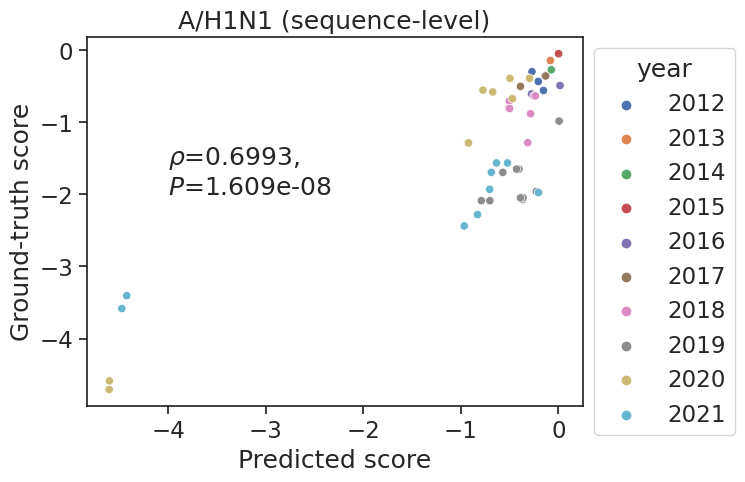

In [9]:
all_dfs["neg_gt_score_seq"] = -all_dfs["gt_score_seq"]

ax = sns.scatterplot(data=all_dfs[all_dfs["coverage_seq"] > seq_threshold], x="neg_score", y="neg_gt_score_seq", hue="year") # , size="coverage_clade"
ax.set_xlabel("Predicted score")
ax.set_ylabel("Ground-truth score")
ax.set_title("A/%s (sequence-level)" % subtype.upper())
if subtype == "h3n2":
#         ax.set_title(f"$\\rho=%.4lf,P=%.4lf$\n$R=%.4lf,P=%.4lf$" % (rho, rho_p, r, r_p))
    ax.text(-5.5, -2., f"$\\rho$=%.4lf, \n$P$=%.4g" % (our_res_seq))
elif subtype == "h1n1":
    ax.text(-4, -2, f"$\\rho$=%.4lf, \n$P$=%.4g" % (our_res_seq))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plt.savefig("figs/scores_%s_from_%d_seq_level.pdf" % (subtype, start_point), format='pdf', bbox_inches='tight')
plt.show()

In [10]:
all_results_df = pd.DataFrame(all_results,
                   columns=["model", "confidence_threshold_seq","Seq-R","Seq-P","#vaccine_seq"])



In [11]:
all_results_df["dominance model"] = [x.split("___")[0] for x in all_results_df["model"]]
all_results_df["hi model"] = [x.split("___")[1] for x in all_results_df["model"]]
all_results_df

,model,confidence_threshold_seq,Seq-R,Seq-P,#vaccine_seq,dominance model,hi model
0,LM___Avg,0.4,0.285083,4.478050e-02,50,LM,Avg
1,EVEscape___VaxSeer,0.4,0.377764,6.837482e-03,50,EVEscape,VaxSeer
2,EVEscape___Avg,0.4,0.314978,2.588418e-02,50,EVEscape,Avg
3,CSCS___Avg,0.4,0.294311,3.801866e-02,50,CSCS,Avg
4,AA sub___CNN,0.4,0.520616,1.062923e-04,50,AA sub,CNN
5,VaxSeer___VaxSeer,0.4,0.699325,1.609467e-08,50,VaxSeer,VaxSeer
6,VaxSeer___Avg,0.4,0.270435,5.750405e-02,50,VaxSeer,Avg
7,AA sub___BLOSUM,0.4,0.459392,7.909267e-04,50,AA sub,BLOSUM
8,AA sub___LR+,0.4,0.279272,4.952125e-02,50,AA sub,LR+
9,CSCS___VaxSeer,0.4,0.475939,4.768909e-04,50,CSCS,VaxSeer


/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


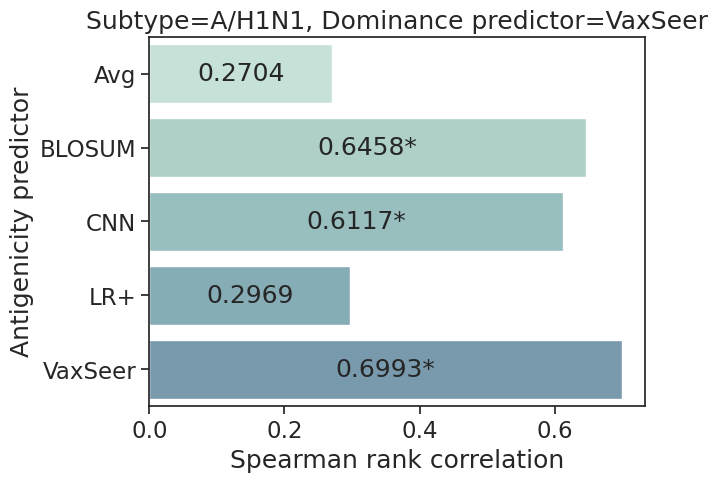

In [12]:
hi_result_matrix = all_results_df[all_results_df["dominance model"] == our_model ]
# print(hi_result_matrix)

hi_result_matrix["Seq-R"] = np.asarray(hi_result_matrix["Seq-R"], dtype=np.float32)
# hi_result_matrix = hi_result_matrix[~hi_result_matrix["hi model"].isin(["gt", "pretrain", "oracle_2023-04"])]
hi_result_matrix = hi_result_matrix.sort_values(by=['hi model'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])

ax = sns.barplot(hi_result_matrix, x="Seq-R", y="hi model", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5)) # , palette="pastel"

# print(hi_result_matrix)

# for i in ax.containers:
#     ax.bar_label(i,fmt="%.4f", label_type="center")
    
for i in ax.containers:
    display_labels = []
    for value, p in zip(hi_result_matrix["Seq-R"], hi_result_matrix["Seq-P"]):
        if p < 0.01:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
    ax.bar_label(i,labels=display_labels, label_type="center")

ax.set_ylabel("Antigenicity predictor")
ax.set_xlabel("Spearman rank correlation")
ax.set_title("Subtype=%s, Dominance predictor=%s" % ( "A/" + subtype.replace("_", "/").upper(), our_model) )
plt.savefig("figs/main_res_clade_%s_from_%d_hi.pdf" % (subtype, 2012), format='pdf', bbox_inches='tight')
plt.show()


/data/rsg/nlp/wenxian/miniconda3/envs/torchlit/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


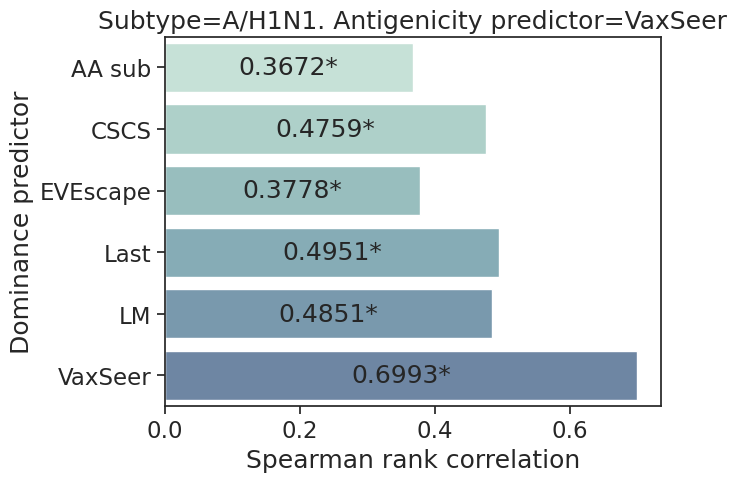

In [13]:

hi_result_matrix = all_results_df[all_results_df["hi model"] == our_model]
hi_result_matrix["Seq-R"] = np.asarray(hi_result_matrix["Seq-R"], dtype=np.float32)
hi_result_matrix = hi_result_matrix[~hi_result_matrix["dominance model"].isin(["gt", "oracle"])]
hi_result_matrix = hi_result_matrix.sort_values(by=['dominance model'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])

ax = sns.barplot(hi_result_matrix, x="Seq-R", y="dominance model", orient="h", palette=sns.cubehelix_palette(start=.5, rot=-.5, dark=.5))

for i in ax.containers:
    display_labels = []
    for value, p in zip(hi_result_matrix["Seq-R"], hi_result_matrix["Seq-P"]):
        if p < 0.01:
            display_labels.append("%.4f*" % value)
        else:
            display_labels.append("%.4f" % value)
    ax.bar_label(i,labels=display_labels, label_type="center")

ax.set_ylabel("Dominance predictor")
ax.set_xlabel("Spearman rank correlation")
ax.set_title("Subtype=%s. Antigenicity predictor=%s" % ( "A/" + subtype.replace("_", "/").upper(), our_model ))
plt.savefig("figs/main_res_clade_%s_from_%d_domiance.pdf" % (subtype, 2012), format='pdf', bbox_inches='tight')
plt.show()


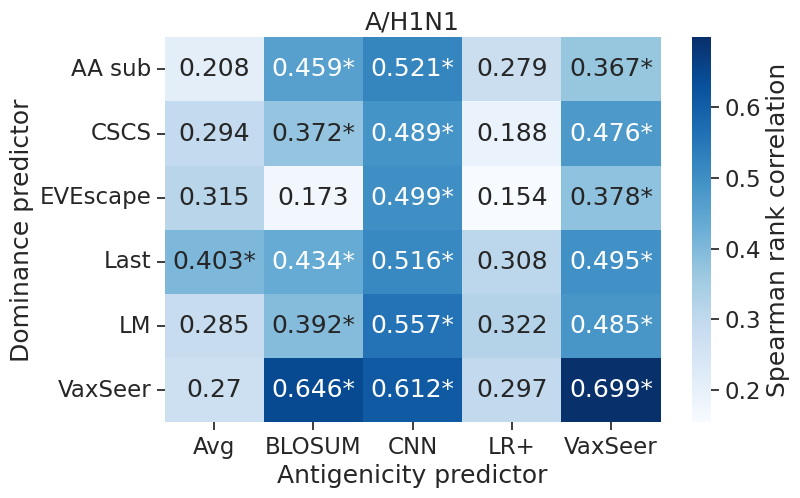

In [14]:

result_matrix = pd.DataFrame(np.array(result_matrix_seq), columns=['dominance predictor', 'hi predictor', 'R'])
result_matrix_seq_pvalue = pd.DataFrame(np.asarray(result_matrix_seq_pvalue), columns=['dominance predictor', 'hi predictor', 'P'])

mm = result_matrix.pivot("dominance predictor", "hi predictor", "R")
mm_pvalue = result_matrix_seq_pvalue.pivot("dominance predictor", "hi predictor", "P")

mm = mm.sort_values(by=['dominance predictor'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])
mm_pvalue = mm_pvalue.sort_values(by=['dominance predictor'], key=lambda col: ["a" + x if x != "our" else "z" + x for x in col.str.lower()])

fig, ax = plt.subplots(figsize=(8,5))

annotations = [[""] * mm_pvalue.shape[1] for _ in range(mm_pvalue.shape[0])]
for i in range(mm_pvalue.shape[0]):
    for j in range(mm_pvalue.shape[1]):
#         print(mm_pvalue)
        if mm_pvalue.to_numpy(float)[i, j]<0.01:
            annotations[i][j] = "%.3g*" % mm.to_numpy(float)[i, j]
        else:
            annotations[i][j] = "%.3g" % mm.to_numpy(float)[i, j]
annotations = np.asarray(annotations)
# ax = sns.heatmap(mm.astype(float), annot=True, fmt='.3g', cmap="Blues", cbar_kws={'label': 'Spearman rank correlation'})

ax = sns.heatmap(mm.astype(float), annot=annotations, fmt="s", cmap="Blues", cbar_kws={'label': 'Spearman rank correlation'})

ax.set_title("A/%s" % subtype.upper())
ax.set_xlabel("Antigenicity predictor")
ax.set_ylabel("Dominance predictor")

plt.savefig("figs/main_res_seqs_%s_from_%d.pdf" % (subtype, 2012), format='pdf', bbox_inches='tight')
plt.show()